# Advanced simulations of a 2D Ising model

## 6.1 **Wolff cluster algorithm**
**Wolff cluster algorithm** Implement the Wolff cluster algorithm for the simulation of a 2D Ising model, with periodic boundary conditions.

**Cluster size statistics** By assuming $k_B = 1$ and $J = 1$, simulate the 2D Ising model ($L = 50$) for different temperatures: the critical temperature $T_c = \frac{2}{ln(1+\sqrt{2})}$, a high temperature $T_h = 2T_c$, and a low temperature $T_l = T_c/2$. Collect the cluster sizes of the Wolff algorithm and plot their histograms for the three temperatures. What can one note?

**Autocorrelation time** For some values of L, compute the autocorrelation time $\tau$ at $T_c$ of the magnetization time series for (a) the single-spin flip algorithm, and (b) the Wolff algorithm. Plot them in log-log scale vs L. Do they scale with L as expected?

In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
from IPython.display import display, Math

In [2]:
def load_matrices_from_file(filename):
    matrices = {}
    with open(filename, 'r') as file:
        lines = file.readlines()
        i = 0
        while i < len(lines):
            if lines[i].startswith("T="):
                metadata = lines[i].strip().split()
                T = float(metadata[0].split('=')[1])
                t = int(metadata[1].split('=')[1])
                
                matrix = []
                L = 50
                for j in range(L):
                    i += 1
                    row = list(map(int, lines[i].strip().split()))
                    matrix.append(row)
                matrices[(T, t)] = np.array(matrix)
            i += 1
            if i < len(lines) and lines[i].strip() == "":
                i += 1  # skip the next line if it's empty
    
    return matrices

def get_matrix(matrices, T, t):
    return matrices.get((T, t))

def load_from_file(filename):
    matrices = {}
    with open(filename, 'r') as file:
        while True:
            # Read the metadata line
            line = file.readline()
            if not line:
                break

            if line.startswith("T="):
                metadata = line.strip().split()
                T = float(metadata[0].split('=')[1])
                
                # read the matrix data line directly into a numpy array
                data_line = file.readline().strip()
                row = np.fromstring(data_line, sep=' ', dtype=float)

                # store the array in the dictionary
                matrices[(T)] = row

            # skip the next line if it's empty
            file.readline()
    return matrices

def get_collection(matrices, T):
    return matrices.get((T))

In [3]:
%%time
# load data: all data have been collected together in order to enhance computational speed
spins = load_matrices_from_file('ising_wolff.txt')
energies = load_from_file('ising_energies_wolff.txt')
magnetizations = load_from_file('ising_magnetizations_wolff.txt')
clusters = load_from_file('ising_clusters_wolff.txt')

CPU times: total: 0 ns
Wall time: 113 ms


In [7]:
def variance(A, avg_A):
    # MC estimate of the variance, as described in the notes
    return np.sum((A-avg_A)**2)/(A.shape[0]-1)

def cv(T, A, avg_A):
    return variance(A, avg_A)/(T**2)

def chi(T, A, avg_A, L):
    return L*L*variance(A, avg_A)/T
    
def equilibrium_stat(M, E, T, L, tail):
    # in order to identify the equilibrium time, I selected a "tail" number of elements and calculated the mean and average of them
    # the idea is that in the last tail elements, the equilibrium has been reached and this information can be used to identify 
    # all elements in the range mean(tail) +- std(tail) as equilibium values, and consequently the equilibration time
    m_last = np.mean(M[-tail:])
    m_last_std = np.std(M[-tail:])
    t_eq = np.where((M >= m_last - m_last_std) & (M <= m_last + m_last_std))[0][0]

    # remove all the elements before equilibrium time
    m_eq = M[t_eq:]
    e_eq = E[t_eq:]

    # calculate averages and sigmas 
    avg_M = np.mean(m_eq)
    sigma_M = np.sqrt(variance(m_eq,avg_M)/m_eq.shape[0]) # error on the mean
    avg_E = np.mean(e_eq)
    sigma_E = np.sqrt(variance(e_eq,avg_E)/e_eq.shape[0]) # error on the mean
    specific_heat = cv(T, e_eq, avg_E)
    magnetic_susceptibility = chi(T, m_eq, avg_M, L)
    return t_eq, avg_M, sigma_M, avg_E, sigma_E, specific_heat, magnetic_susceptibility

T_C = 2/np.log(1+np.sqrt(2))
T_range = [np.around(T_C/2,2), np.around((T_C*0.98),2), np.around(T_C*2,2)]
L_range = [25, 50,100]

In [8]:
T_C = 2/np.log(1+np.sqrt(2))
T_range = [T_C/2, T_C, T_C*2]
L = 50
i_range_tot = []
labels = [1/2, 1, 2]
# compute the thermodynamic limit of magnetization as tool to calculate equilibration time
M_lim = [(1 - (1 / np.sinh(2 / T))**2)**(1/8) if T < T_C else 0 for T in T_range]

N = 1000
i_range_tot = [0]
for i in np.linspace(2,0,3, dtype="int"):
    i_range_tot.append(int(N/(10**i)))
i_range_tot

[0, 10, 100, 1000]

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

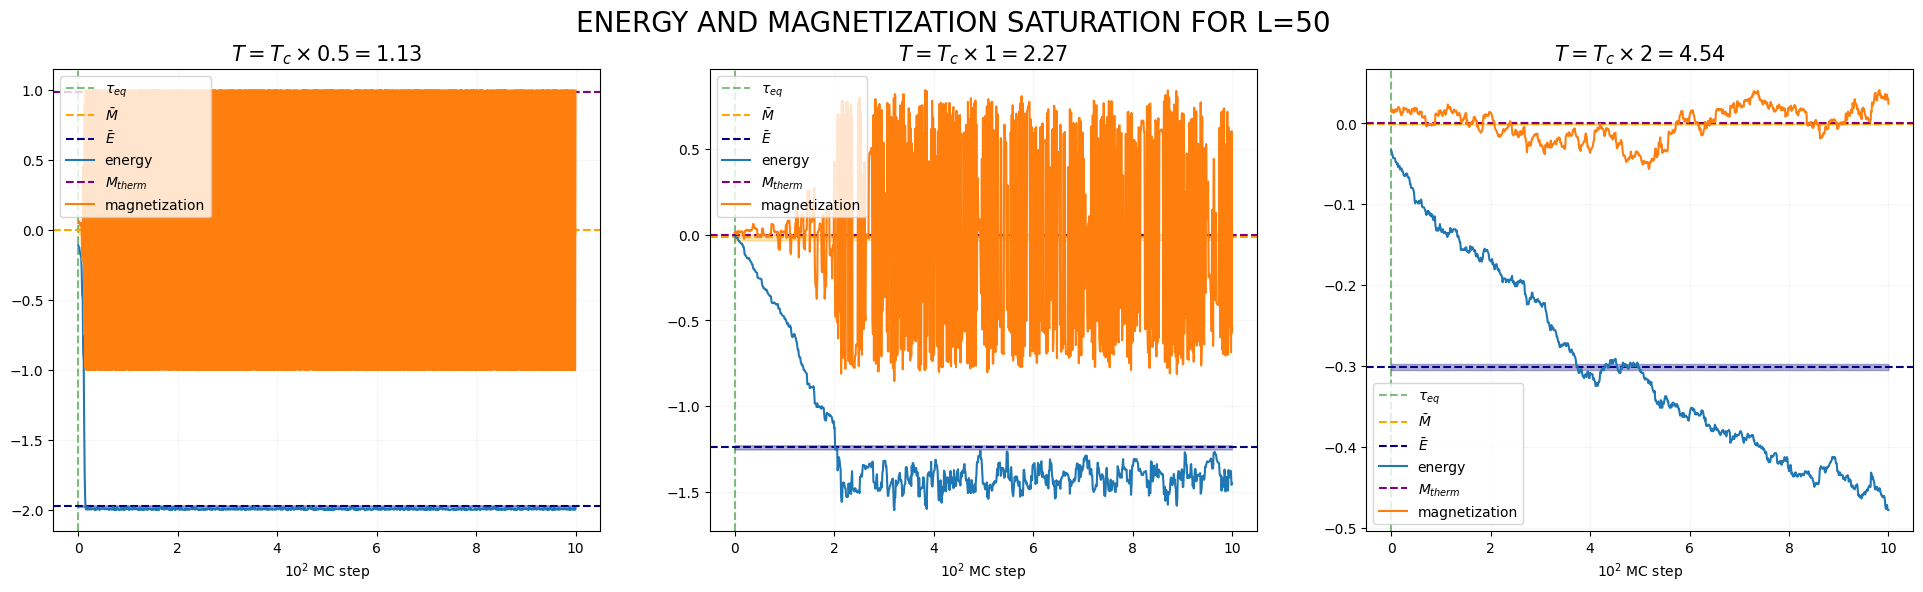

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=len(L_range),figsize=(24,6))
plt.suptitle("ENERGY AND MAGNETIZATION SATURATION FOR L={}".format(L), fontsize=20)
for j, T in enumerate(T_range):
    
    M = get_collection(magnetizations, np.around(T,2))
    E = get_collection(energies, np.around(T,2))
    x_range = [i/10**2 for i in range(E.shape[0])]
    
    t_eq, avg_M, sigma_M, avg_E, sigma_E, specific_heat, magnetic_susceptibility = equilibrium_stat(M, E, T, L, 100) 
    display(Math(r"T={:.2f}: \tau_{{eq}}={}, \bar{{E}} = {:.5f} \pm {:.5f}, \bar{{M}} = {:.5f} \pm {:.5f}, C_V = {:.5f}, \chi = {:.5f}".format(T, t_eq, avg_E, sigma_E, avg_M, sigma_M, specific_heat, magnetic_susceptibility)))   
    ax[j].axvline(t_eq/10**5, label=r"$\tau_{eq}$", color="green", linestyle="--", alpha=0.5)
    ax[j].axhline(avg_M, label=r"$\bar{{M}}$", color="orange", linestyle="--")
    ax[j].fill_between(x_range, avg_M - sigma_M, avg_M + sigma_M, color="orange", alpha=0.3)
    ax[j].axhline(avg_E, label=r"$\bar{{E}}$", color="navy", linestyle="--")
    ax[j].fill_between(x_range, avg_E - sigma_E, avg_E + sigma_E, color="navy", alpha=0.3)
        
    ax[j].plot(x_range, E, label="energy")
    ax[j].axhline(M_lim[j]*np.sign(M[-1]), label=r"$M_{therm}$", color="purple", linestyle="--")
    ax[j].plot(x_range, M, label="magnetization")

    ax[j].set_title(r"$T=T_c \times {}={:.2f}$".format(labels[j],T),fontsize=15)
    ax[j].set_xlabel(r"$10^2$ MC step")
    ax[j].legend(loc="best")
    ax[j].grid(alpha=0.1)
    ax[j].set_title(r"$T=T_c \times {}={:.2f}$".format(labels[j],T),fontsize=15)
    ax[j].set_xlabel(r"$10^2$ MC step")
    ax[j].legend(loc="best")
    ax[j].grid(alpha=0.1)
    
plt.show()

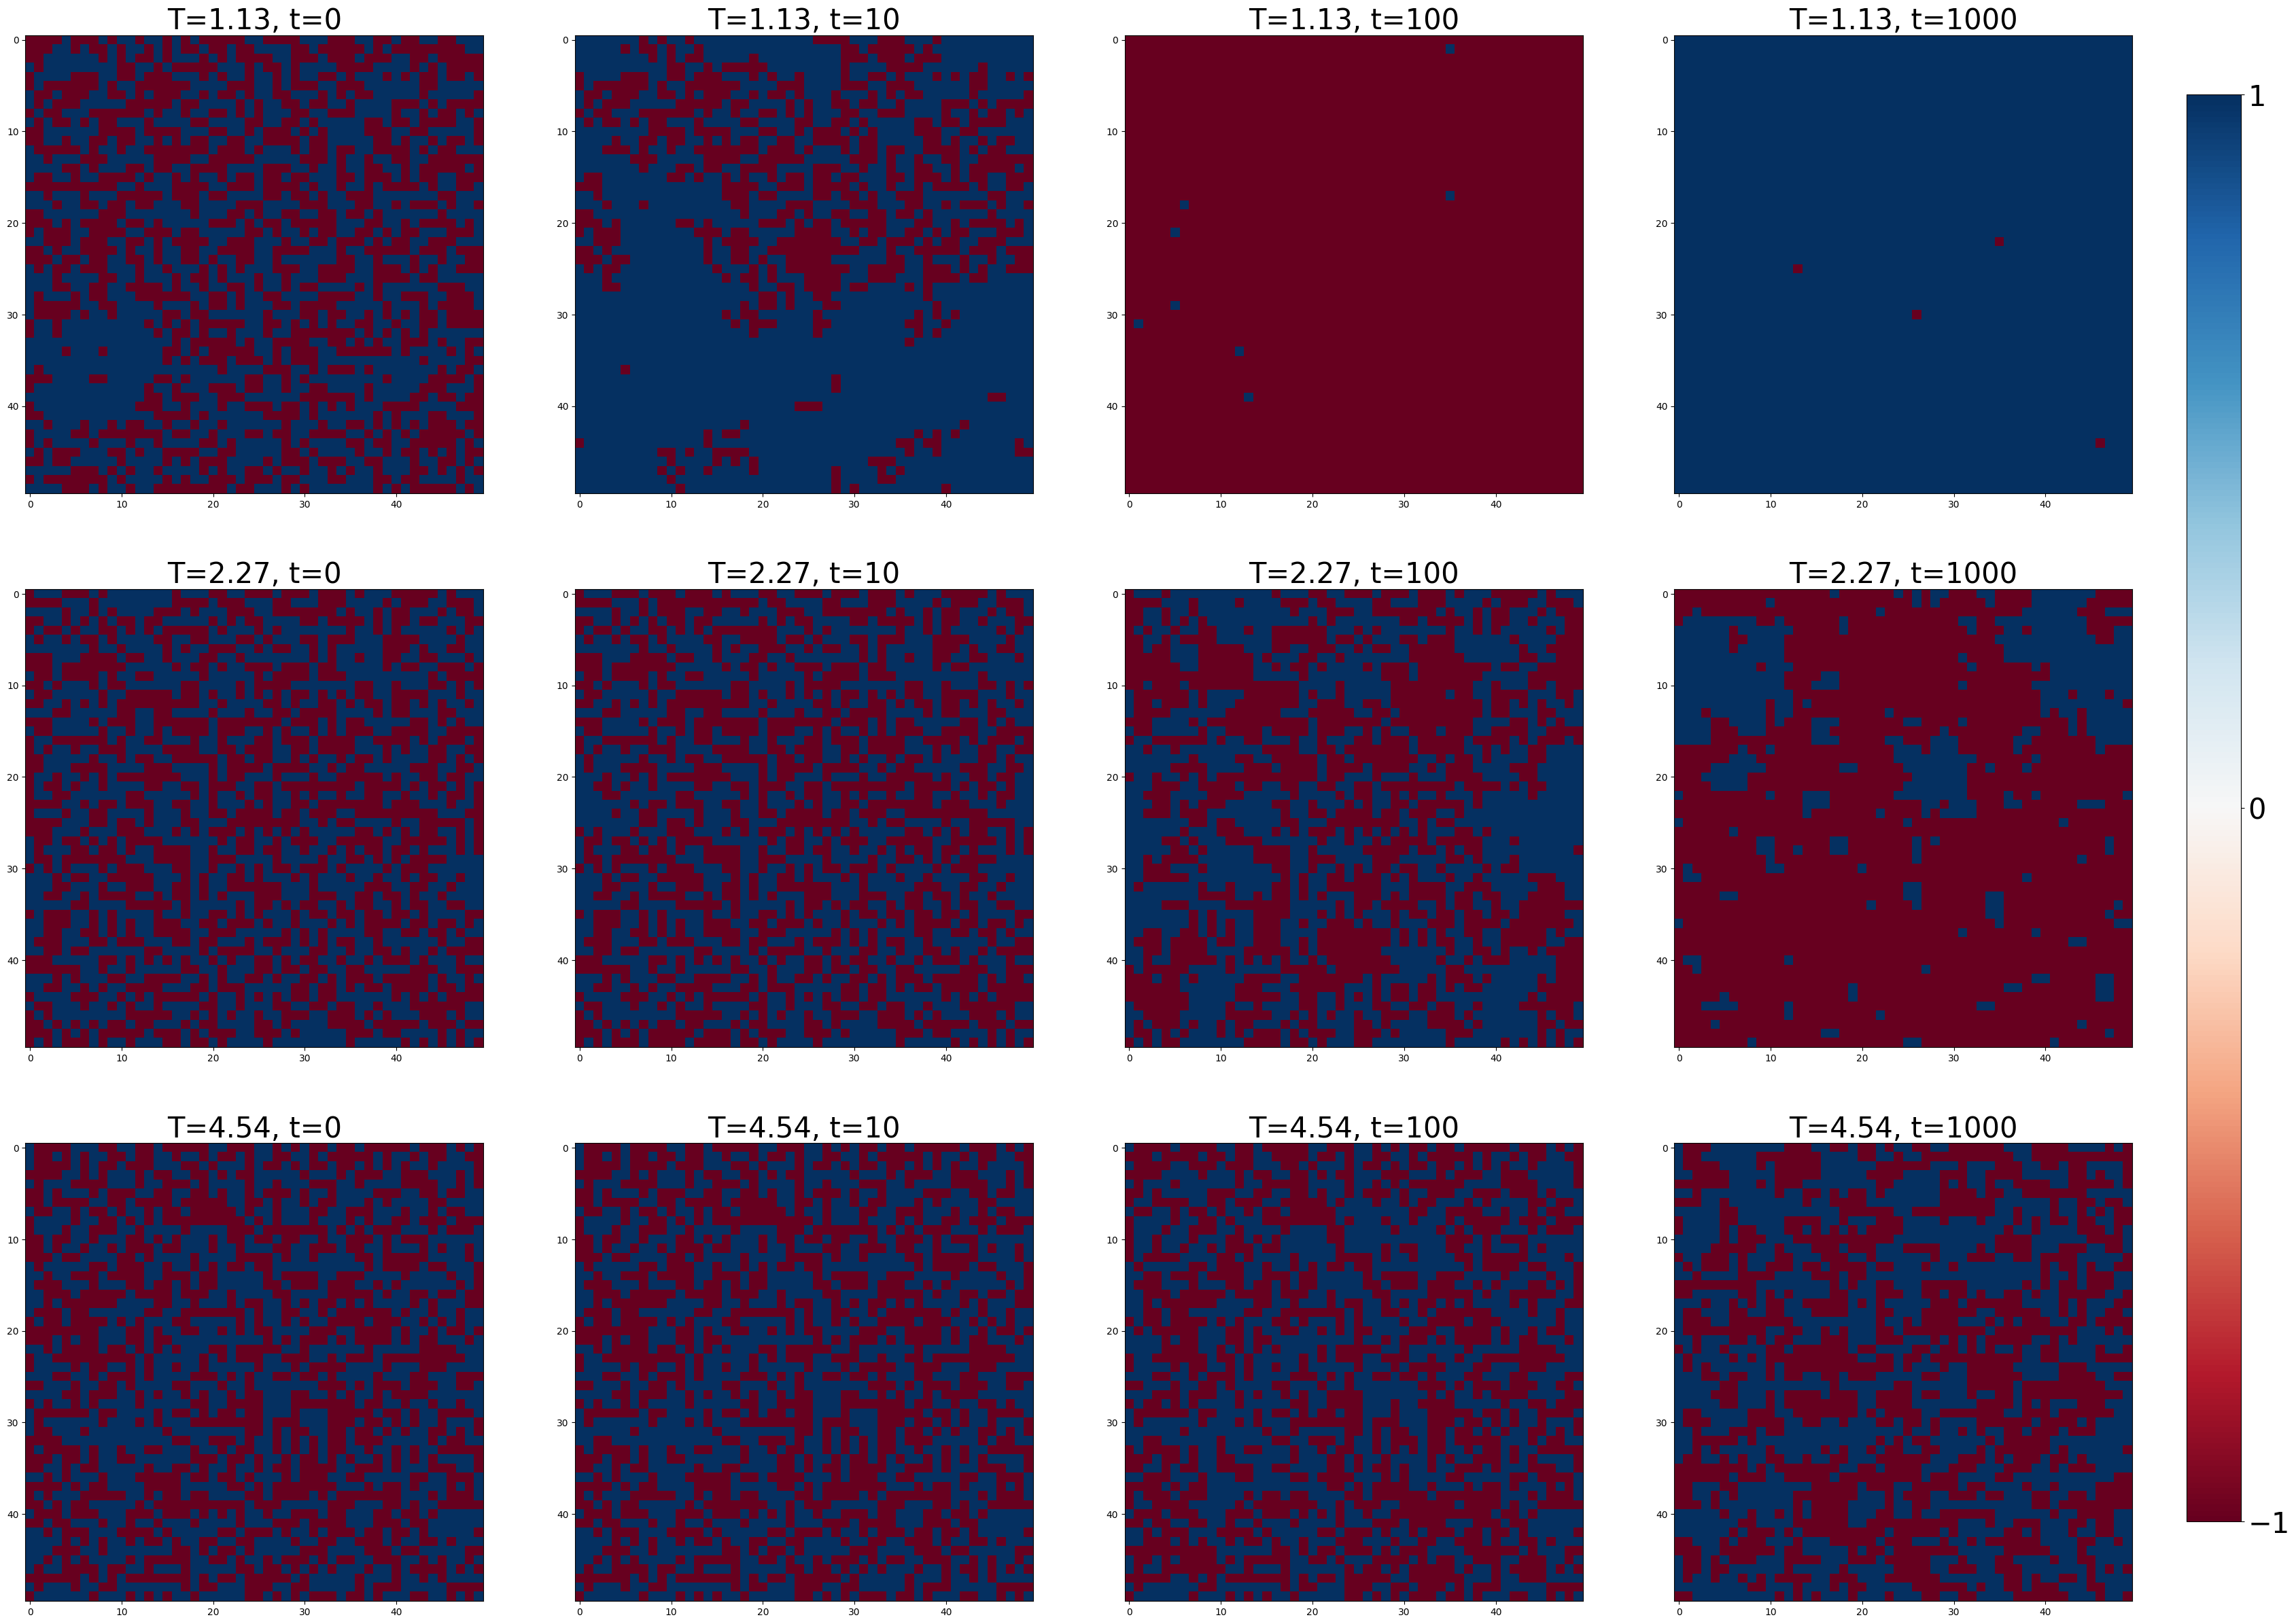

In [10]:
cmap = plt.get_cmap('RdBu') 
t_range = i_range_tot
L_mesh, i_mesh = np.meshgrid(T_range, t_range, indexing='ij')
fig, ax = plt.subplots(nrows=len(T_range), ncols=len(t_range),figsize=(len(t_range)*10,10*len(T_range)))
for j, T in enumerate(T_range):
    for k, t in enumerate(t_range):
        matrix = get_matrix(spins, np.around(T,2), t)
        im = ax[j][k].imshow(matrix, cmap=cmap, interpolation='nearest', vmin=-1, vmax=1)
        ax[j][k].set_title("T={:.2f}, t={}".format(T, t), fontsize=30)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = plt.colorbar(im, cax=cbar_ax, ticks=[-1, 0, 1])
cbar.ax.tick_params(labelsize=30) 
plt.show()

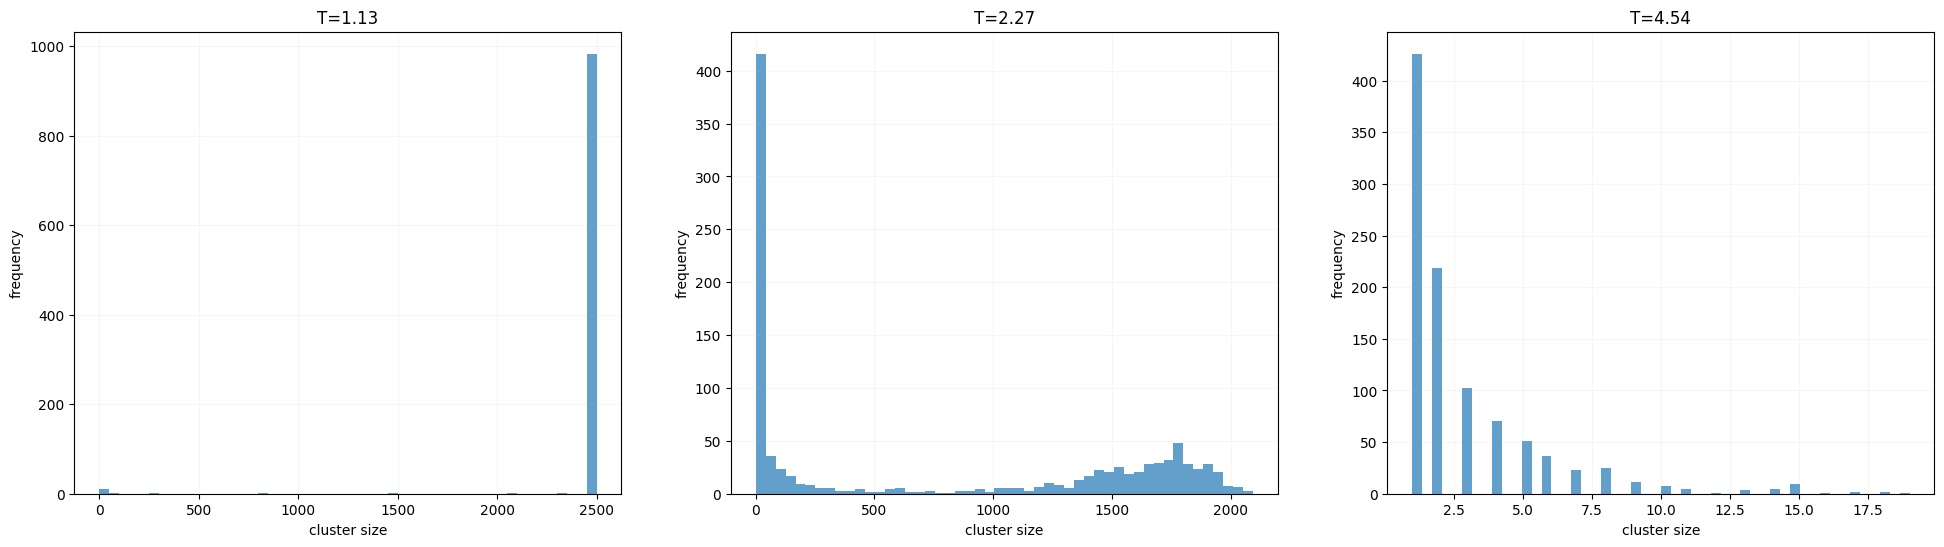

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24,6))
for j, T in enumerate(T_range):
    c = get_collection(clusters, np.around(T,2))
    ax[j].hist(c, 50, alpha=0.7)
    ax[j].set_xlabel("cluster size")
    ax[j].set_ylabel("frequency")
    ax[j].set_title("T={:.2f}".format(T))
    ax[j].grid(alpha=0.1)

In [12]:
def load_from_file_glauber(filename):
    matrices = {}
    with open(filename, 'r') as file:
        while True:
            # Read the metadata line
            line = file.readline()
            if not line:
                break

            if line.startswith("T="):
                metadata = line.strip().split()
                T = float(metadata[0].split('=')[1])
                L = int(metadata[1].split('=')[1])
                
                # read the matrix data line directly into a numpy array
                data_line = file.readline().strip()
                row = np.fromstring(data_line, sep=' ', dtype=float)

                # store the array in the dictionary
                matrices[(T, L)] = row

            # skip the next line if it's empty
            file.readline()
    return matrices

def get_collection_glauber(matrices, T, L):
    return matrices.get((T, L))

In [13]:
from statsmodels.tsa.stattools import acf

CPU times: total: 1min 50s
Wall time: 3min 12s


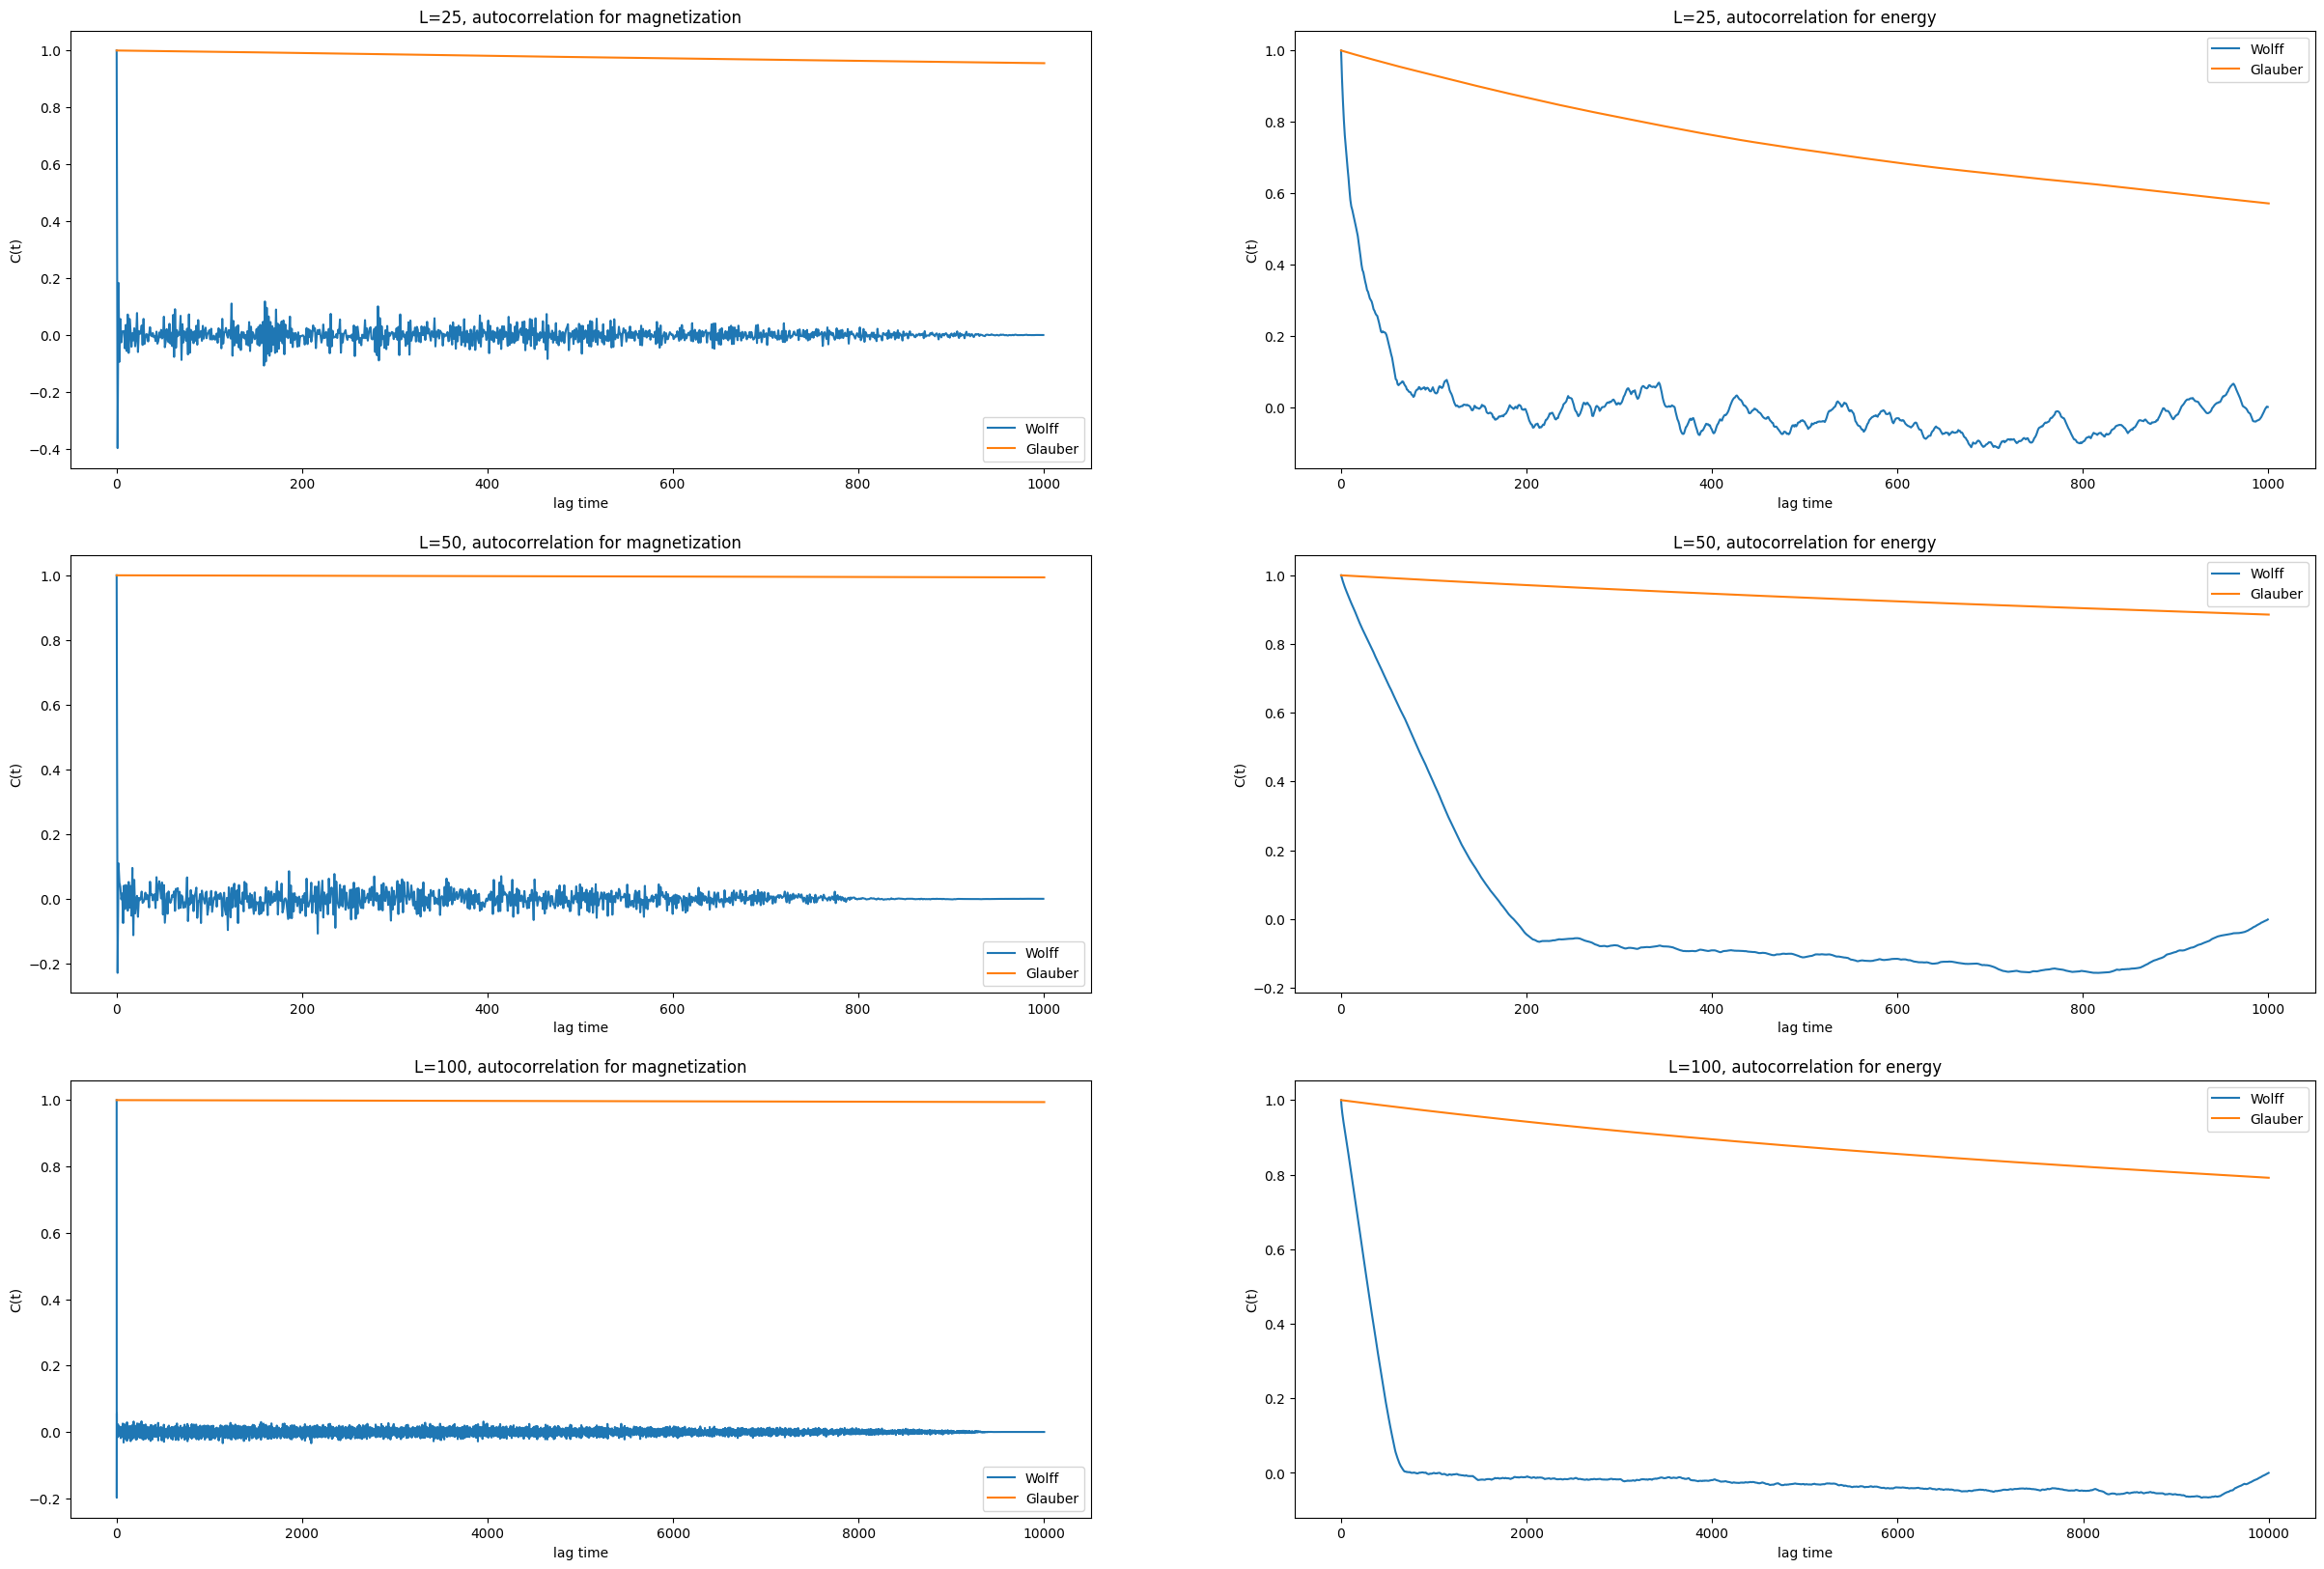

In [16]:
%%time
import statsmodels.api as sm

# load other trials
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(30,20))
energies_glauber = load_from_file_glauber('ising_energies_glauber.txt')
magnetizations_glauber = load_from_file_glauber('ising_magnetizations_glauber.txt')

energies_g_25 = get_collection_glauber(energies_glauber, np.around(T_C,2), 25)
magnetizations_g_25 = get_collection_glauber(magnetizations_glauber, np.around(T_C,2), 25)
energies_25 = load_from_file('ising_energies_wolff2.txt')
magnetizations_25 = load_from_file('ising_magnetizations_wolff2.txt')
clusters_25 = load_from_file('ising_clusters_wolff2.txt')
M_25 = get_collection(magnetizations_25, np.around(T_C,2))
E_25 = get_collection(energies_25, np.around(T_C,2))
c_25 = get_collection(clusters_25, np.around(T_C,2))
W_25_m = sm.tsa.acf(M_25, nlags = M_25.shape[0])
W_25_e = sm.tsa.acf(E_25, nlags = E_25.shape[0])
W_25_m_g = sm.tsa.acf(magnetizations_g_25, nlags=M_25.shape[0]) 
W_25_e_g = sm.tsa.acf(energies_g_25, nlags = E_25.shape[0])
ax[0][0].plot(range(len(W_25_m)), W_25_m, label="Wolff")
ax[0][0].plot(range(len(W_25_m_g)), W_25_m_g, label="Glauber")
ax[0][0].set_title("L=25, autocorrelation for magnetization")
ax[0][1].plot(range(len(W_25_e)), W_25_e, label="Wolff")
ax[0][1].plot(range(len(W_25_e_g)), W_25_e_g, label="Glauber")
ax[0][1].set_title("L=25, autocorrelation for energy")

M_50 = get_collection(magnetizations, np.around(T_C,2))
E_50 = get_collection(energies, np.around(T_C,2))
c_50 = get_collection(clusters, np.around(T_C,2))
energies_g_50 = get_collection_glauber(energies_glauber, np.around(T_C,2), 50)
magnetizations_g_50 = get_collection_glauber(magnetizations_glauber, np.around(T_C,2), 50)
W_50_m = sm.tsa.acf(M_50, nlags=M_50.shape[0]) 
W_50_e = sm.tsa.acf(E_50, nlags=E_50.shape[0])
W_50_m_g = sm.tsa.acf(magnetizations_g_50, nlags=M_50.shape[0]) 
W_50_e_g = sm.tsa.acf(energies_g_50, nlags=E_50.shape[0])
ax[1][0].plot(range(len(W_50_m)), W_50_m, label="Wolff")
ax[1][0].plot(range(len(W_50_m_g)), W_50_m_g, label="Glauber")
ax[1][0].set_title("L=50, autocorrelation for magnetization")
ax[1][1].plot(range(len(W_50_e)), W_50_e, label="Wolff")
ax[1][1].plot(range(len(W_50_e_g)), W_50_e_g, label="Glauber")
ax[1][1].set_title("L=50, autocorrelation for energy")

energies_100 = load_from_file('ising_energies_wolff3.txt')
magnetizations_100 = load_from_file('ising_magnetizations_wolff3.txt')
clusters_100 = load_from_file('ising_clusters_wolff3.txt')
M_100 = get_collection(magnetizations_100, np.around(T_C,2))
E_100 = get_collection(energies_100, np.around(T_C,2))
c_100 = get_collection(clusters_100, np.around(T_C,2))
energies_g_100 = get_collection_glauber(energies_glauber, np.around(T_C,2), 100)
magnetizations_g_100 = get_collection_glauber(magnetizations_glauber, np.around(T_C,2), 100)
W_100_m = sm.tsa.acf(M_100, nlags=M_100.shape[0]) 
W_100_e = sm.tsa.acf(E_100, nlags=E_100.shape[0])
W_100_m_g = sm.tsa.acf(magnetizations_g_100, nlags=M_100.shape[0]) 
W_100_e_g = sm.tsa.acf(energies_g_100, nlags=E_100.shape[0])
ax[2][0].plot(range(len(W_100_m)), W_100_m, label="Wolff")
ax[2][0].plot(range(len(W_100_m_g)), W_100_m_g, label="Glauber")
ax[2][0].set_title("L=100, autocorrelation for magnetization")
ax[2][1].plot(range(len(W_100_e)), W_100_e, label="Wolff")
ax[2][1].plot(range(len(W_100_e_g)), W_100_e_g, label="Glauber")
ax[2][1].set_title("L=100, autocorrelation for energy")
for i in range(3):
    for j in range(2):
        ax[i][j].set_xlabel("lag time")
        ax[i][j].set_ylabel("C(t)")
        ax[i][j].legend()

<timed exec>:6: RuntimeWarning: overflow encountered in exp


CPU times: total: 1min 16s
Wall time: 1min 38s


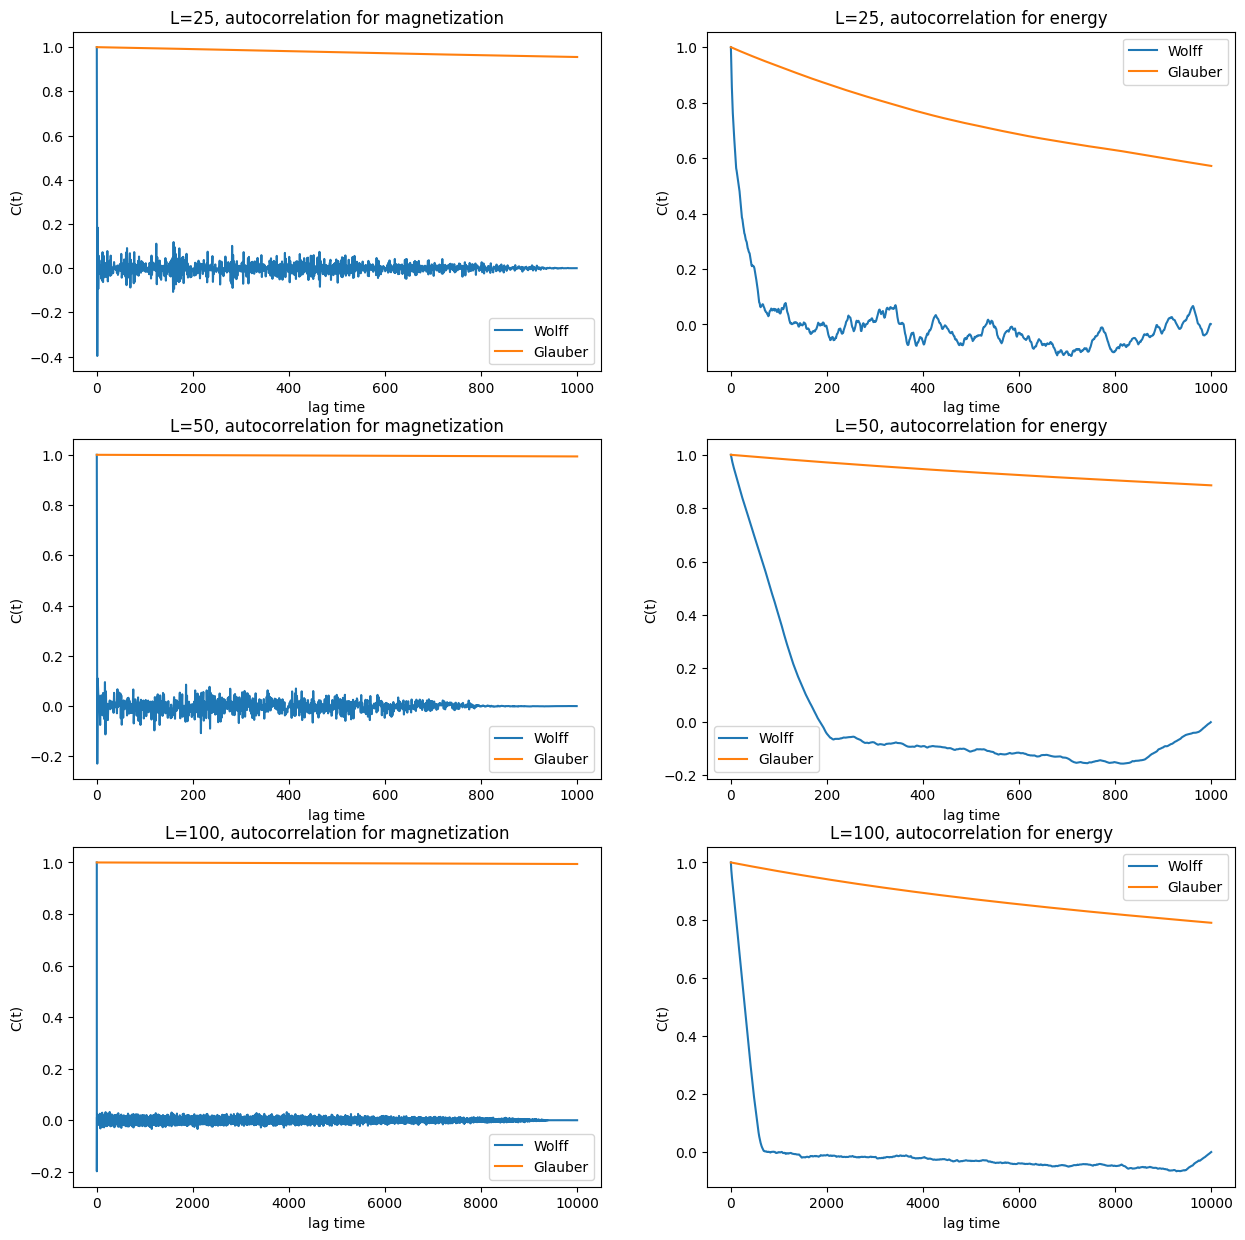

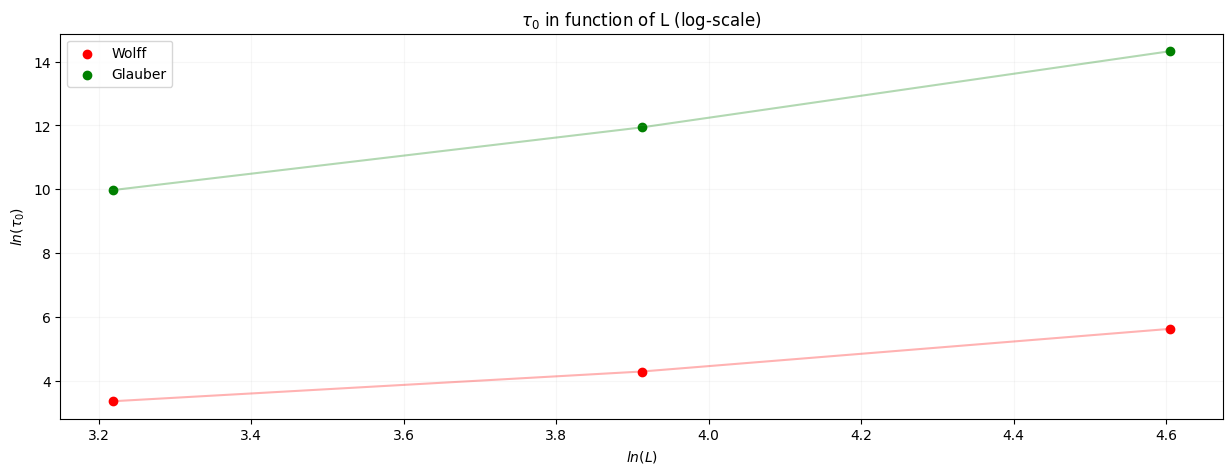

In [23]:
%%time
import statsmodels.api as sm
from scipy.optimize import curve_fit
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15,15))

def fit_exp(x, a, tau0):
    return a*np.exp(-x/tau0)

# load other trials
energies_glauber_load = load_from_file_glauber('ising_energies_glauber.txt')
magnetizations_glauber_load = load_from_file_glauber('ising_magnetizations_glauber.txt')

def autocorrelation(filename_wolff_E, filename_wolff_M, L):
    # load data
    energies_wolff = load_from_file(filename_wolff_E)
    magnetizations_wolff = load_from_file(filename_wolff_M)
    M = get_collection(magnetizations_wolff, np.around(T_C,2))
    E = get_collection(energies_wolff, np.around(T_C,2))
    energies_glauber = get_collection_glauber(energies_glauber_load, np.around(T_C,2), L)
    magnetizations_glauber = get_collection_glauber(magnetizations_glauber_load, np.around(T_C,2), L)

    # compute autocorrelation
    autoc_M_wolff = sm.tsa.acf(M, nlags = M.shape[0])
    autoc_E_wolff = sm.tsa.acf(E, nlags = E.shape[0])
    autoc_M_glau = sm.tsa.acf(magnetizations_glauber, nlags=M.shape[0]) 
    autoc_E_glau = sm.tsa.acf(energies_glauber, nlags = E.shape[0])

    # find tau, integrated autocorrelation time 
    params_M_wolff, errs_M_wolff = curve_fit(fit_exp, np.array(range(autoc_M_wolff.shape[0])), autoc_M_wolff)
    params_E_wolff, errs_E_wolff = curve_fit(fit_exp, np.array(range(autoc_E_wolff.shape[0])), autoc_E_wolff)
    tau_wolff = params_M_wolff[1] if params_M_wolff[1] > params_E_wolff[1] else params_E_wolff[1]
    params_M_glau, errs_M_glau = curve_fit(fit_exp, np.array(range(autoc_M_glau.shape[0])), autoc_M_glau)
    params_E_glau, errs_E_glau = curve_fit(fit_exp, np.array(range(autoc_E_glau.shape[0])), autoc_E_glau)
    tau_glau = params_M_glau[1] if params_M_glau[1] > params_E_glau[1] else params_E_glau[1]
    return autoc_M_wolff, autoc_E_wolff, autoc_M_glau, autoc_E_glau, tau_wolff, tau_glau

autoc_M_wolff25, autoc_E_wolff25, autoc_M_glau25, autoc_E_glau25, tau_wolff25, tau_glau25 = autocorrelation('ising_energies_wolff2.txt', 'ising_magnetizations_wolff2.txt', 25)
ax[0][0].plot(range(len(autoc_M_wolff25)), autoc_M_wolff25, label="Wolff")
ax[0][0].plot(range(len(autoc_M_glau25)), autoc_M_glau25, label="Glauber")
ax[0][0].set_title("L=25, autocorrelation for magnetization")
ax[0][1].plot(range(len(autoc_E_wolff25)), autoc_E_wolff25, label="Wolff")
ax[0][1].plot(range(len(autoc_E_glau25)), autoc_E_glau25, label="Glauber")
ax[0][1].set_title("L=25, autocorrelation for energy")

autoc_M_wolff50, autoc_E_wolff50, autoc_M_glau50, autoc_E_glau50, tau_wolff50, tau_glau50 = autocorrelation('ising_energies_wolff.txt', 'ising_magnetizations_wolff.txt', 50)
ax[1][0].plot(range(len(autoc_M_wolff50)), autoc_M_wolff50, label="Wolff")
ax[1][0].plot(range(len(autoc_M_glau50)), autoc_M_glau50, label="Glauber")
ax[1][0].set_title("L=50, autocorrelation for magnetization")
ax[1][1].plot(range(len(autoc_E_wolff50)), autoc_E_wolff50, label="Wolff")
ax[1][1].plot(range(len(autoc_E_glau50)), autoc_E_glau50, label="Glauber")
ax[1][1].set_title("L=50, autocorrelation for energy")

autoc_M_wolff100, autoc_E_wolff100, autoc_M_glau100, autoc_E_glau100, tau_wolff100, tau_glau100 = autocorrelation('ising_energies_wolff3.txt', 'ising_magnetizations_wolff3.txt', 100)
ax[2][0].plot(range(len(autoc_M_wolff100)), autoc_M_wolff100, label="Wolff")
ax[2][0].plot(range(len(autoc_M_glau100)), autoc_M_glau100, label="Glauber")
ax[2][0].set_title("L=100, autocorrelation for magnetization")
ax[2][1].plot(range(len(autoc_E_wolff100)), autoc_E_wolff100, label="Wolff")
ax[2][1].plot(range(len(autoc_E_glau100)), autoc_E_glau100, label="Glauber")
ax[2][1].set_title("L=100, autocorrelation for energy")

for i in range(3):
    for j in range(2):
        ax[i][j].set_xlabel("lag time")
        ax[i][j].set_ylabel("C(t)")
        ax[i][j].legend()

fig, axx = plt.subplots(nrows=1, ncols=1, figsize=(15,5))

tau_wolff = [tau_wolff25, tau_wolff50, tau_wolff100]
tau_glau = [tau_glau25, tau_glau50, tau_glau100]

axx.scatter(np.log(np.array([25, 50,100])), np.log(np.array(tau_wolff)), label="Wolff", color="red")
axx.plot(np.log(np.array([25, 50,100])), np.log(np.array(tau_wolff)), alpha = 0.3, color="red")
axx.scatter(np.log(np.array([25, 50,100])), np.log(np.array(tau_glau)), label="Glauber", color="green")
axx.plot(np.log(np.array([25, 50,100])), np.log(np.array(tau_glau)), alpha = 0.3, color="green")
axx.set_title(r"$\tau_0$ in function of L (log-scale)")
axx.set_xlabel(r"$ln(L)$")
axx.set_ylabel(r"$ln(\tau_0)$")
axx.legend()
axx.grid(alpha=0.1)



## 6.2 **Multiple Markov chains**
Implement multiple Markov chains for the Ising model. 
* Check if the energy distributions of adjacent chains
 are overlapped.
* Record the swapping rate between chains.
* Compare the autocorrelation times of the chains when the swapping is allowed and when it is not (thus making the Markov chains effectively single ones).

In [106]:
def load_matrix(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
    
    # Determine the number of rows and columns
    num_rows = len(lines)
    num_cols = len(lines[0].strip().split())
    
    # Initialize the matrix with float data type to handle both integers and floats
    matrix = np.zeros((num_rows, num_cols), dtype=float)
    
    # Fill the matrix with values
    for i, line in enumerate(lines):
        row = list(map(float, line.strip().split()))
        matrix[i] = row
    
    return matrix


In [116]:
energies_MCC = load_matrix("ising_energies_MCC.txt")
magnetizations_MCC = load_matrix("ising_magnetizations_MCC.txt")
swaps = load_matrix("MCC_swaps.txt")
energies_MCC2 = load_matrix("ising_energies_MCC_2.txt")
magnetizations_MCC2 = load_matrix("ising_magnetizations_MCC_2.txt")
swaps2 = load_matrix("MCC_swaps_2.txt")

In [117]:
T_max = 5.0
T_min = 1.0
N_chains = energies_MCC.shape[1]
N_step = energies_MCC.shape[0]
step = (T_max - T_min) / (N_chains - 1)
T_values = []
for i in range(N_chains):
    T_values.append(T_min + i * step)

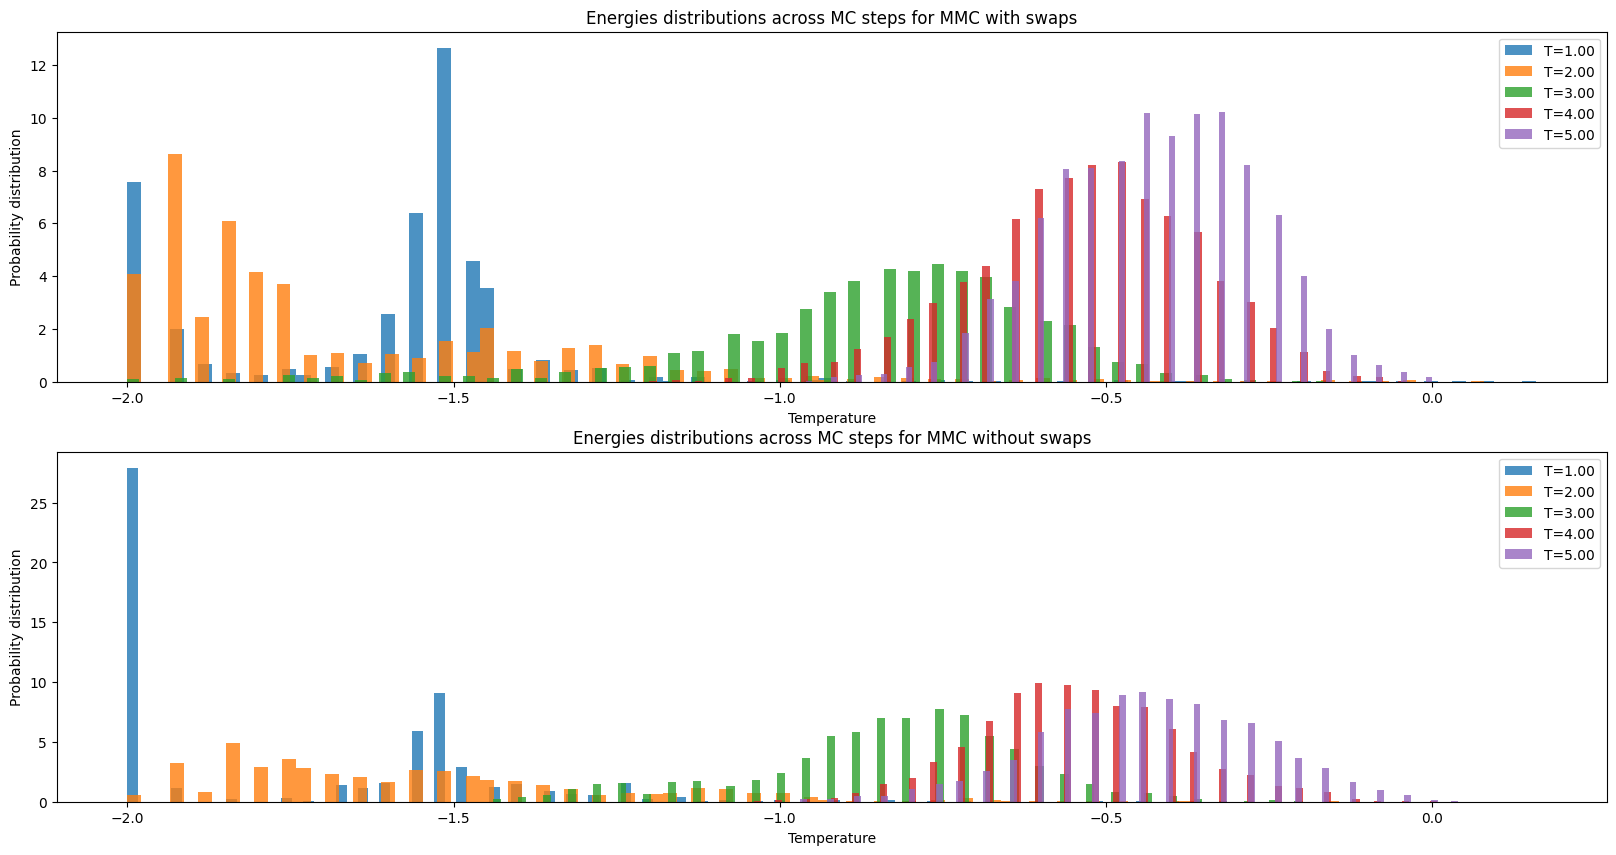

In [127]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20,10))
for i, T in enumerate(T_values):
    ax[0].hist(energies_MCC[:,i], 100, density=True, label="T={:.2f}".format(T), alpha=0.8)
    ax[1].hist(energies_MCC2[:,i], 100, density=True, label="T={:.2f}".format(T), alpha=0.8)
ax[0].set_title("Energies distributions across MC steps for MMC with swaps")
ax[1].set_title("Energies distributions across MC steps for MMC without swaps")

for i in range(2):
    ax[i].legend()
    ax[i].set_xlabel("Temperature")
    ax[i].set_ylabel("Probability distribution")
    #ax[i].set_ylim(-2,0)

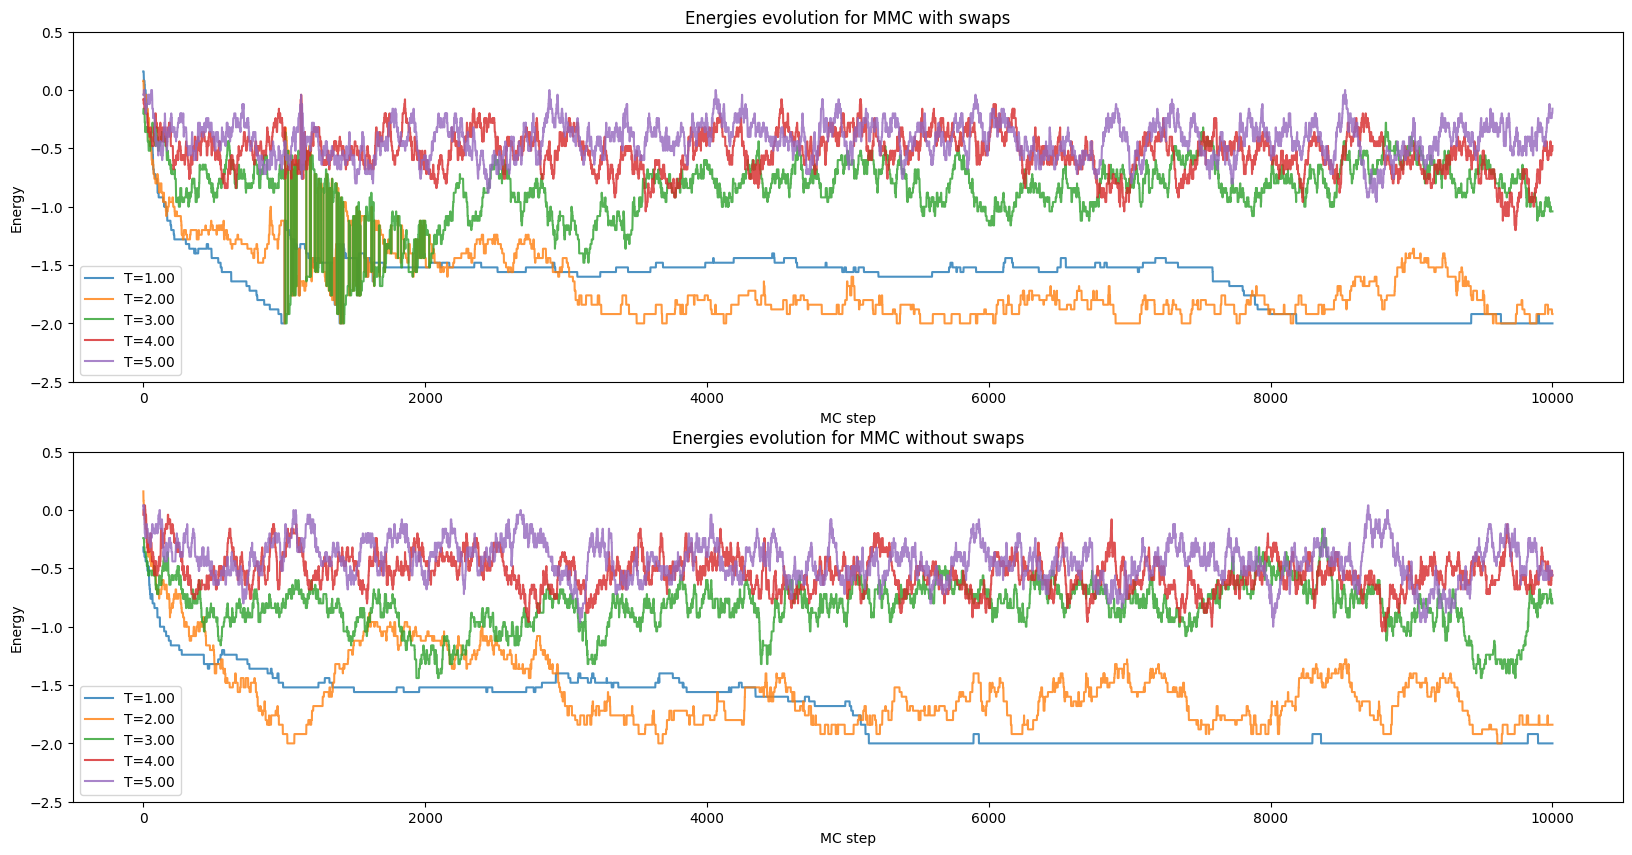

In [125]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20,10))
for i, T in enumerate(T_values):
    ax[0].plot(range(N_step), energies_MCC[:,i], label="T={:.2f}".format(T), alpha=0.8)
    ax[1].plot(range(N_step), energies_MCC2[:,i], label="T={:.2f}".format(T), alpha=0.8)
ax[0].set_title("Energies evolution for MMC with swaps")
ax[1].set_title("Energies evolution for MMC without swaps")

for i in range(2):
    ax[i].legend()
    ax[i].set_xlabel("MC step")
    ax[i].set_ylabel("Energy")
    ax[i].set_ylim(-2.5,0.5)


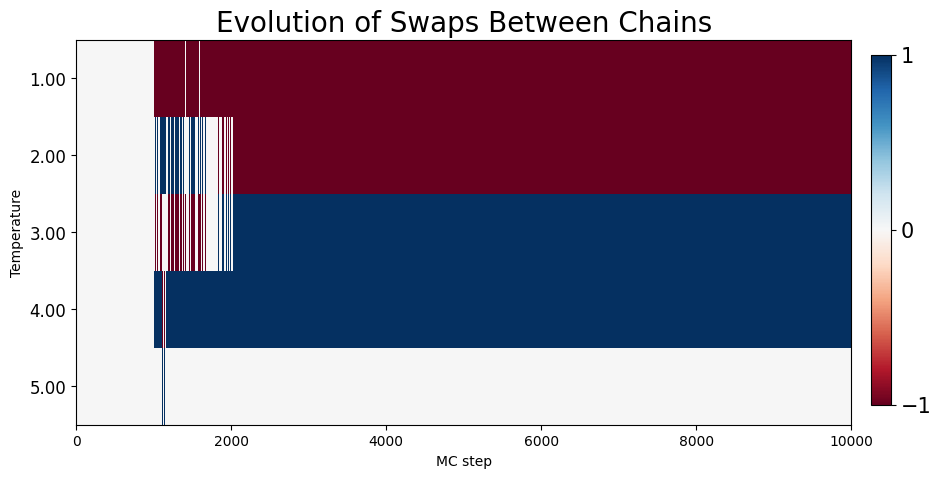

In [120]:
# plot the dynamics of the swaps: when the chain is in -1 swap state it means that we started from this configuration 
# and went to the new configuration in 1 state. If a state return in 0 state, it means that the previous swap has been reversed.
cmap = plt.get_cmap('RdBu')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
im = ax.imshow(swaps.T, cmap=cmap, interpolation='nearest', aspect='auto', vmin=-1, vmax=1)
ax.set_title("Evolution of Swaps Between Chains", fontsize=20)
ax.set_xlabel("MC step")
ax.set_yticks(np.arange(len(T_values)))  # Positions for the ticks
ax.set_yticklabels([f"{T:.2f}" for T in T_values], fontsize=12)
ax.set_ylabel("Temperature")
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = plt.colorbar(im, cax=cbar_ax, ticks=[-1, 0, 1])
cbar.ax.tick_params(labelsize=15)
plt.show()

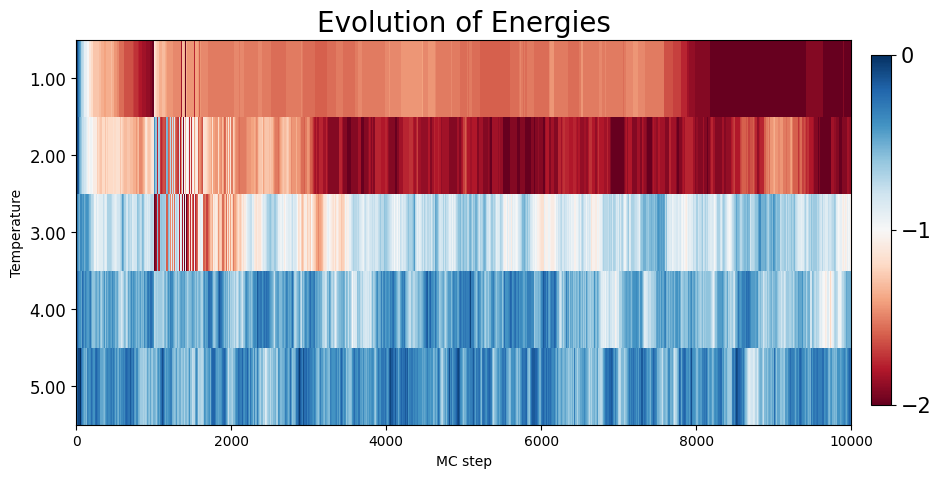

In [121]:
# plot the dynamics of the swaps: when the chain is in -1 swap state it means that we started from this configuration 
# and went to the new configuration in 1 state. If a state return in 0 state, it means that the previous swap has been reversed.
cmap = plt.get_cmap('RdBu')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
im = ax.imshow(energies_MCC.T, cmap=cmap, interpolation='nearest', aspect='auto', vmin=-2, vmax=0)
ax.set_title("Evolution of Energies", fontsize=20)
ax.set_xlabel("MC step")
ax.set_yticks(np.arange(len(T_values)))  # Positions for the ticks
ax.set_yticklabels([f"{T:.2f}" for T in T_values], fontsize=12)
ax.set_ylabel("Temperature")
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = plt.colorbar(im, cax=cbar_ax, ticks=[-2, -1, 0])
cbar.ax.tick_params(labelsize=15)
plt.show()

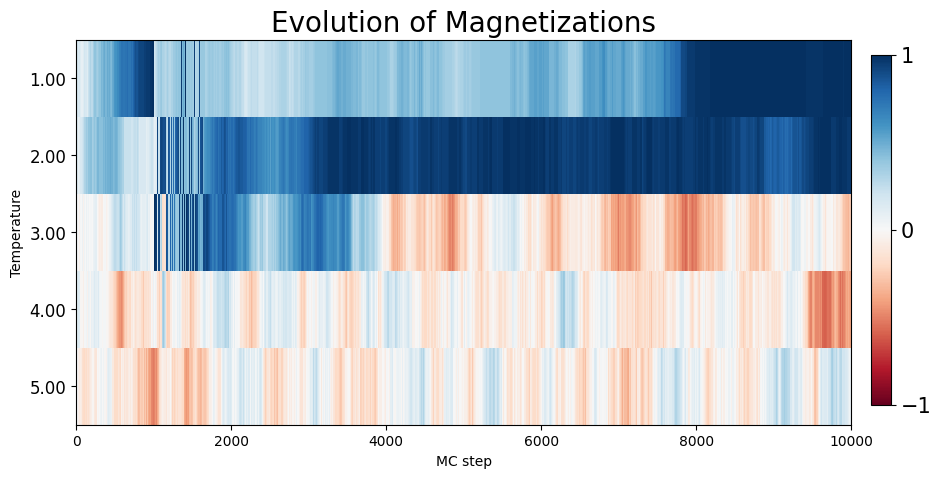

In [122]:
# plot the dynamics of the swaps: when the chain is in -1 swap state it means that we started from this configuration 
# and went to the new configuration in 1 state. If a state return in 0 state, it means that the previous swap has been reversed.
cmap = plt.get_cmap('RdBu')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
im = ax.imshow(magnetizations_MCC.T, cmap=cmap, interpolation='nearest', aspect='auto', vmin=-1, vmax=1)
ax.set_title("Evolution of Magnetizations", fontsize=20)
ax.set_xlabel("MC step")
ax.set_yticks(np.arange(len(T_values)))  # Positions for the ticks
ax.set_yticklabels([f"{T:.2f}" for T in T_values], fontsize=12)
ax.set_ylabel("Temperature")
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = plt.colorbar(im, cax=cbar_ax, ticks=[-1, 0, 1])
cbar.ax.tick_params(labelsize=15)
plt.show()

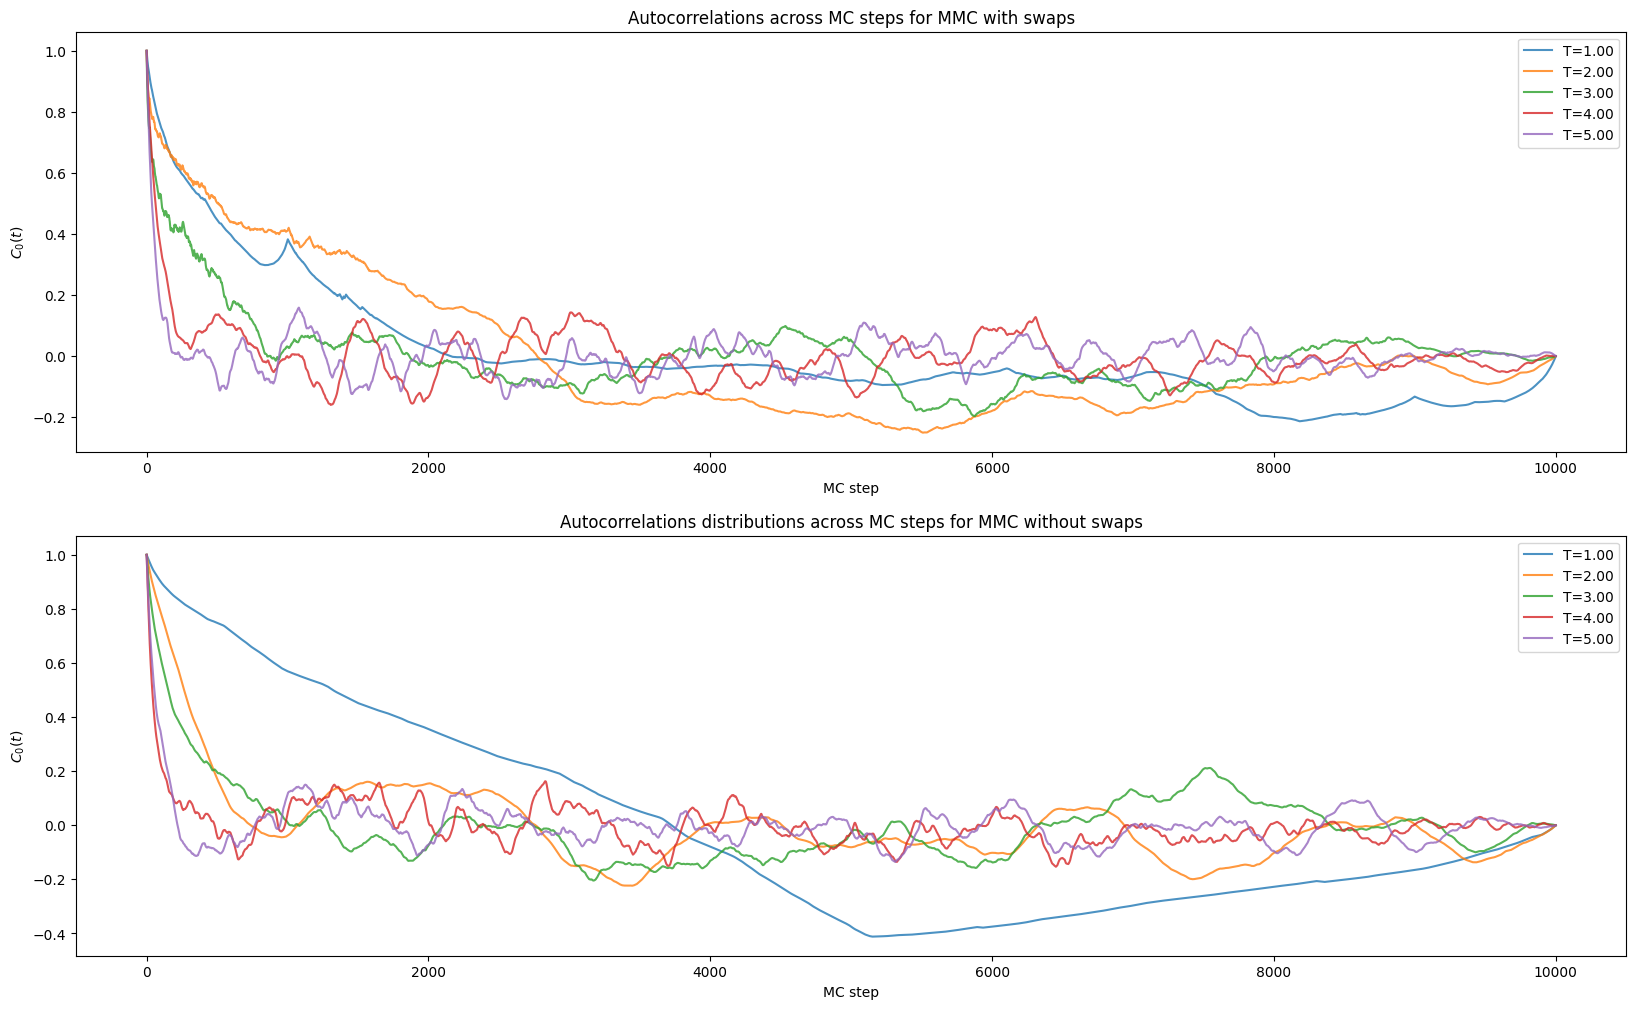

In [123]:
from scipy.optimize import curve_fit

def fit_exp(x, a, tau0):
    return a*np.exp(-x/tau0)
    
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20,12))
tau_swap = []
tau_noswap = []
for i, T in enumerate(T_values):
    tmp_e = sm.tsa.acf(energies_MCC[:,i], nlags = N_step)
    params_E, errs_E = curve_fit(fit_exp, np.array(range(N_step)), tmp_e)
    tau_swap.append(params_E[1])
    tmp_e_noswap = sm.tsa.acf(energies_MCC2[:,i], nlags = N_step)
    params_E_noswap, errs_E_noswap = curve_fit(fit_exp, np.array(range(N_step)), tmp_e_noswap)
    tau_noswap.append(params_E_noswap[1])
    ax[0].plot(range(N_step), tmp_e, label="T={:.2f}".format(T), alpha=0.8)
    ax[1].plot(range(N_step), tmp_e_noswap, label="T={:.2f}".format(T), alpha=0.8)
ax[0].set_title("Autocorrelations across MC steps for MMC with swaps")
ax[1].set_title("Autocorrelations distributions across MC steps for MMC without swaps")

for i in range(2):
    ax[i].legend()
    ax[i].set_xlabel("MC step")
    ax[i].set_ylabel(r"$C_0(t)$")

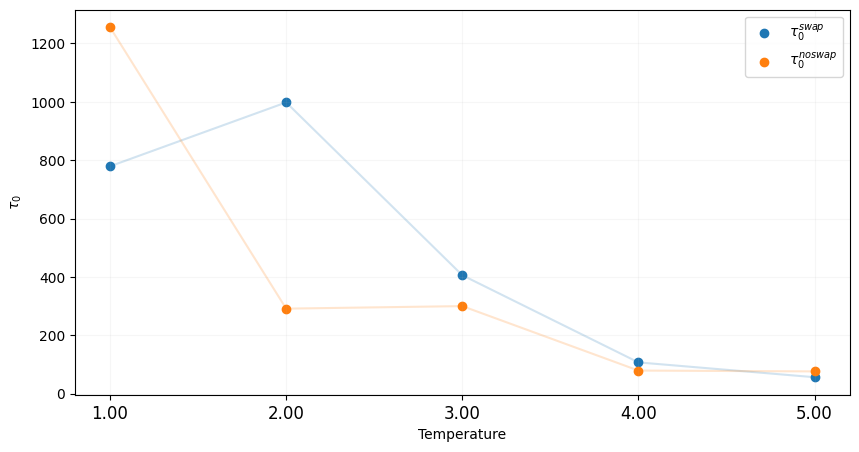

In [124]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
ax.scatter(range(N_chains), tau_swap, label=r"$\tau_0^{swap}$")
ax.plot(range(N_chains), tau_swap, alpha = 0.2)
ax.scatter(range(N_chains), tau_noswap, label=r"$\tau_0^{no swap}$")
ax.plot(range(N_chains), tau_noswap, alpha = 0.2)
ax.set_xticks(np.arange(len(T_values)))  # Positions for the ticks
ax.set_xticklabels([f"{T:.2f}" for T in T_values], fontsize=12)
ax.set_xlabel("Temperature")
ax.set_ylabel(r"$\tau_0$")
ax.legend()
ax.grid(alpha=0.1)